In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from tqdm.notebook import tqdm
import pickle
import timeit
from td_algorithm_funcs import get_prop_v2, get_prop_abs_v2, get_hists_v4, get_rate, simulate_traj
import pandas as pd

# One example

In [22]:
# Mean movment in dt -> dx = s*sqrt(dt) -> dx = sqrt(2 D dt)

In [23]:
# k = 1
# tau = 0.5
# D = 1/2
# s = np.sqrt(2*D)
# N_t = 100
# dt = tau/4 if tau > 0 else 5e-2
# dx = 1/2
#sb = 20

k = 3
tau = 0.2
D = 1e-6
s = np.sqrt(2*D)
N_t = 50
dt = tau/4 if tau > 0 else 5e-2
dx = 4e-4 #1e-4
sb = 15*dx#0.005

f = 30
N_p = 8_000


ntau = round(tau/dt)
ts = np.arange(0,N_t)*dt
ts_r = ts[1:]


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

# def force(x,*args):
#      return -k*x


def force(x,*args):
    return -k*x**3*1e6

i_zero = np.argmin(force(x_s)**2)

In [24]:
N_x

31

In [25]:
prop = get_prop_abs_v2(x_s, force,D,dt,dx, side='lr')
hists, unaltered_props, total_prob = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop, thresh = 5e-7)

CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/50 [00:00<?, ?it/s]

Total number of final states: (22345,)


In [26]:
#prop_old = get_prop_v2(x_s, force,D,dt,dx)
#hists_old, unaltered_props_old, total_prob_old = get_hists_v4(N_t = N_t, N_x=N_x,ntau=ntau,i_zero=i_zero,prop=prop_old, thresh = 5e-7)

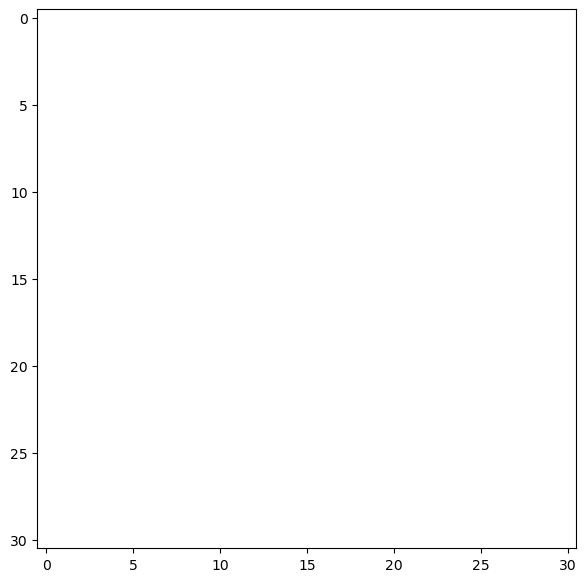

In [27]:
plt.figure(figsize=(15,7))
plt.imshow(prop[-2])

In [28]:
pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+ntau+2)*f, ntau=ntau*f, s=s, dt=dt/f,border=0, force=force)
all_pos = pos[0]
sim_hists = np.stack([np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))])
sim_ts = np.arange(0, len(all_pos[0]))*dt/f -tau-dt

  0%|          | 0/1559 [00:00<?, ?it/s]

/tmp/ipykernel_11263/3964552566.py:38: RuntimeWarning: overflow encountered in multiply
  return -k*x**3*1e6
/tmp/ipykernel_11263/3964552566.py:38: RuntimeWarning: overflow encountered in power
  return -k*x**3*1e6
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/td_algorithm_funcs.py:92: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt


  0%|          | 0/1680 [00:00<?, ?it/s]

In [29]:
np.max(all_pos)

nan

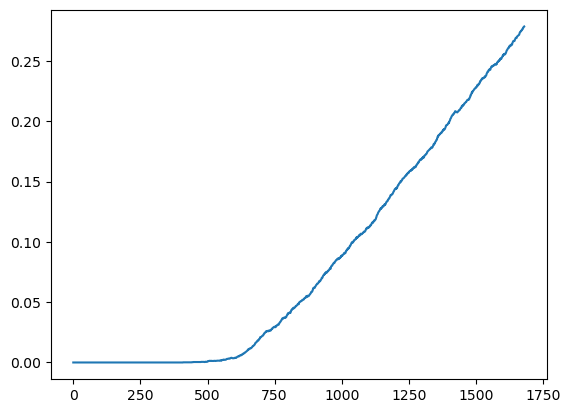

In [30]:
div_particle = (np.isnan(all_pos).sum(0) + ( np.abs(all_pos) > sb).sum(0))/N_p
plt.plot(div_particle)

In [31]:
all_pos.shape

(8000, 1680)

In [32]:
ntau

4

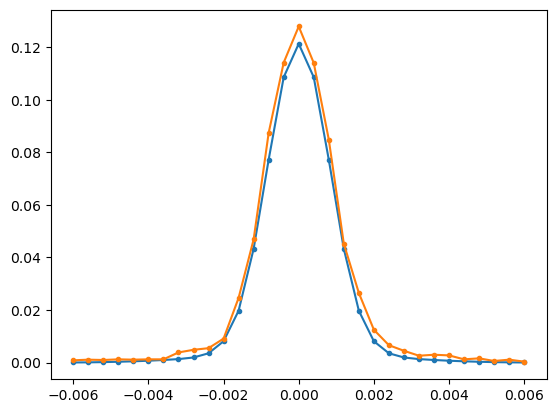

In [33]:
idx = 49
plt.plot(x_s,hists[idx]*np.cumprod(unaltered_props)[idx],'.-')
#plt.plot(x_s,hists_old[idx],'.-')
plt.plot(x_s,sim_hists[f*(idx+ntau+1)]/N_p,'.-')

In [35]:
sim_var = np.var(pos, axis = 1)
sim_p = sim_hists[:,:]/np.sum(sim_hists, axis = 1)[:,None]
sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)

num_p = hists[:,:]/np.sum(hists, axis = 1)[:,None]
num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)

#num_p_old = hists_old[:,:]/np.sum(hists_old, axis = 1)[:,None]
#num_var_old = np.sum(num_p_old*x_s[None,:]**2 - (num_p_old*x_s[None,:])**2, axis = 1)

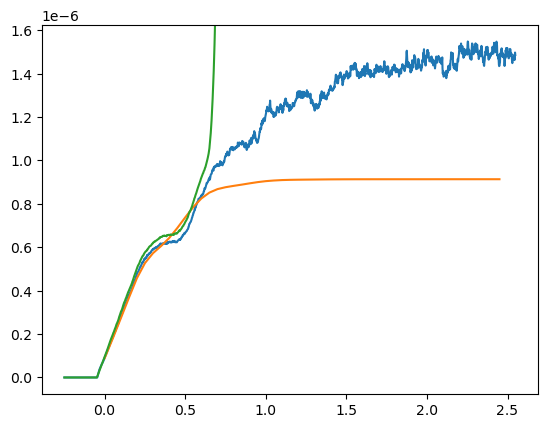

In [36]:

plt.plot(sim_ts,sim_hist_var)
plt.plot(ts, num_var)
#plt.plot(ts, num_var_old)
plt.ylim(*plt.ylim())
plt.plot(sim_ts,sim_var[0])

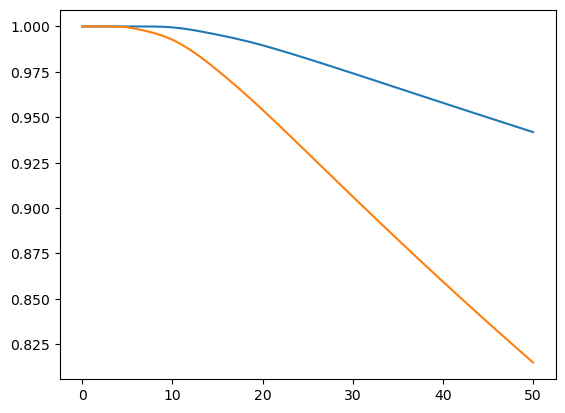

In [43]:
plt.plot(np.cumprod(unaltered_props))
plt.plot(np.cumprod(total_prob))
#plt.ylim(0,2)

# The Loop

In [2]:
k = 3
D = 1e-6
s = np.sqrt(2*D)
N_t = 100
dx = 4e-4 #4e-4
sb = 15*dx#0.005

f = 30
N_p = 8_000


# jump over zero as x point
x_s = np.arange(-sb,sb+1e-6,dx)
bins = np.arange(-sb-dx/2,sb+dx/2+1e-5,dx)
N_x = len(x_s)

ltaus = np.array([0.01, 0.05, 0.1, 0.2,0.3,0.4,0.5,0.6])
sim_vars = np.empty(len(ltaus))
num_vars = np.empty(len(ltaus))
num_vars_2 = np.empty(len(ltaus))
sim_hist_vars = np.empty(len(ltaus))

tau_frac = 4

# def force(x,*args):
#      return -k*x
def force(x,*args):
    return -k*x**3*1e6
i_zero = np.argmin(force(x_s)**2)

In [3]:
for i,ltau in enumerate(tqdm(ltaus)):
    
    
    ldt = ltau/tau_frac if ltau > 0 else 5e-2
    lntau = round(ltau/ldt)
    
    print(ldt, lntau)
    prop = get_prop_abs_v2(x_s, force,D,ldt,dx, side = 'lr')
    hists, unaltered_props, total_prob = get_hists_v4(N_t = N_t, N_x=N_x,ntau=lntau,i_zero=i_zero,prop=prop)
    
    
    pos = simulate_traj(N_p=N_p, N_loop=1, N_t=(N_t+lntau+2)*f, ntau=lntau*f, s=s, dt=ldt/f,border=0, force=force)
    all_pos = pos[0]
    sim_hists = [np.histogram(all_pos[:,j], bins = bins)[0] for j in tqdm(range(all_pos.shape[-1]))]
 
    sim_var = np.var(pos, axis = 1)
    sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]
    sim_hist_var = np.sum(sim_p*x_s[None,:]**2 - (sim_p*x_s[None,:])**2, axis = 1)
    
    num_p = hists[:,:]/np.sum(hists, axis = 1)[:,None]
    num_var = np.sum(num_p*x_s[None,:]**2 - (num_p*x_s[None,:])**2, axis = 1)
    
    sim_vars[i] = np.mean(sim_var[0,-f*N_t//2:])
    num_vars[i] = np.mean(num_var[-N_t//2:])
    sim_hist_vars[i] = np.mean(sim_hist_var[-f*N_t//2:])

    
with open(f'nummeric_results/sim_vs_num_v4_emb{tau_frac}_x4.pkl', 'wb') as file:
    pickle.dump({'ltaus':ltaus,
                 'sim_vars':sim_vars,
                 'sim_hist_vars':sim_hist_vars,
                 'num_vars':num_vars
                }, file)

  0%|          | 0/8 [00:00<?, ?it/s]

0.0025 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (967,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

0.0125 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (5639,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

0.025 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (17271,)


  0%|          | 0/3059 [00:00<?, ?it/s]

/tmp/ipykernel_11263/4124427470.py:28: RuntimeWarning: overflow encountered in multiply
  return -k*x**3*1e6
/tmp/ipykernel_11263/4124427470.py:28: RuntimeWarning: overflow encountered in power
  return -k*x**3*1e6
/home/nils/Programmieren/overdampedDelayHarmonicOscillator/td_algorithm_funcs.py:92: RuntimeWarning: invalid value encountered in add
  pos[:,:,i] = pos[:,:,i-1] + vel[:,:,i-1]*dt


  0%|          | 0/3180 [00:00<?, ?it/s]

0.05 4
CAREFUL: nan in prop, maybe because of to high values in potential


/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (53455,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

0.075 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (81737,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

0.1 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (106443,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

0.125 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (128211,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

0.15 4
CAREFUL: nan in prop, maybe because of to high values in potential


  0%|          | 0/100 [00:00<?, ?it/s]

Total number of final states: (148163,)


  0%|          | 0/3059 [00:00<?, ?it/s]

  0%|          | 0/3180 [00:00<?, ?it/s]

/tmp/ipykernel_11263/1955762168.py:17: RuntimeWarning: invalid value encountered in divide
  sim_p = sim_hists/np.sum(sim_hists, axis = 1)[:,None]


In [14]:
sim_vs_num_v4 = pickle.load(open('nummeric_results/sim_vs_num_v4_emb4_x4.pkl', 'rb'))
ltaus = sim_vs_num_v4['ltaus']
sim_vars = sim_vs_num_v4['sim_vars']
num_vars = sim_vs_num_v4['num_vars']
sim_hist_vars = sim_vs_num_v4['sim_hist_vars']

In [11]:
short_time_approx_var = s**2/(2*k)*(1+k*ltaus)
exact_sol = s**2/(2*k)*(1+np.sin(k*ltaus))/np.cos(k*ltaus)

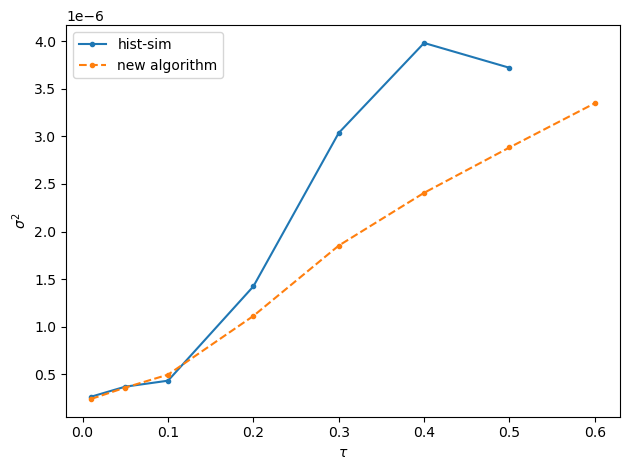

In [19]:
ax = plt.subplot()
#plt.plot(ltaus,sim_vars,'.-', label='sim')
plt.plot(ltaus,sim_hist_vars,'.-', label='hist-sim')
plt.plot(ltaus,num_vars,'.--', label='new algorithm')


if False:
    plt.plot(ltaus,short_time_approx_var ,'.-.',label='short time')
    plt.plot(ltaus[:-1],exact_sol[:-1] ,'.-.',label='exact')

    plt.ylim(1e-7,2e-5)
    plt.vlines([1/np.e /k, np.pi/2/k],*plt.ylim(), color='black')
    plt.text(0.5*1/np.e /k,              2e-7,'Regim I', ha='center', va='center')
    plt.text(0.5*(1/np.e /k+  np.pi/2/k),2e-7,'Regim II',ha='center', va='center')
    plt.text(1.1*(np.pi/2/k),            2e-7,'Regim III',ha='center', va='center')

#plt.yscale('log')
plt.legend()
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\sigma^2$')
plt.tight_layout()
#plt.savefig('Graphic_Results/varianz_compare_x4.pdf')

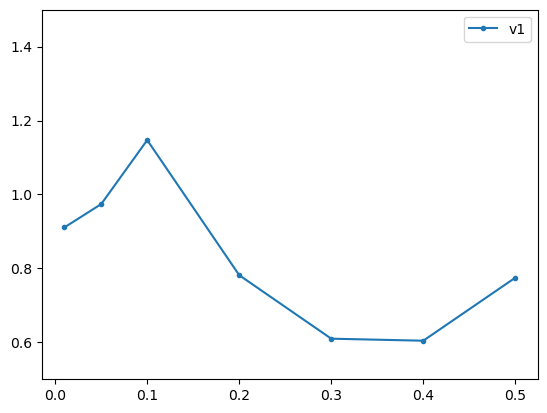

In [21]:
plt.plot(ltaus,num_vars/sim_hist_vars,'.-', label='v1')
if False:
    plt.plot(ltaus,short_time_approx_var/sim_hist_vars,'.-',label='short time')
plt.ylim(0.5,1.5)
plt.legend()